**ip:** ip address of click.  
**app:** app id for marketing.  
**device:** device type id of user mobile phone (e.g., iphone 6 plus, iphone 7, huawei mate 7, etc.)  
**os:** os version id of user mobile phone  
**channel:** channel id of mobile ad publisher  
**click_time:** timestamp of click (UTC)  
**attributed_time:** if user download the app for after clicking an ad, this is the time of the app download  
**is_attributed:** the target that is to be predicted, indicating the app was downloaded  
    

In [ ]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
import gc

In [ ]:
def load_train():
    dtype = {
        "ip":"category",
        "app":"category",
        "device":"category",
        "os":"category",
        "channel":"category",
        "click_time":"str",
        "attributed_time":"str",
        "is_attributed":"int"
    }
    parse_dates=['click_time','attributed_time']
    return dd.read_csv('train_sample.csv',dtype=dtype,parse_dates=parse_dates)

In [ ]:
def load_test():
    dtype = {
        "click_id":"category",
        "app":"category",
        "device":"category",
        "os":"category",
        "channel":"category",
        "click_time":"str"
    }
    parse_dates=['click_time']
    return dd.read_csv('test.csv',dtype=dtype,parse_dates=parse_dates)

In [ ]:
train = load_train()
len(train)

In [ ]:
test = load_test()
test.head()

In [ ]:
train.head()

### FEATURE ENGINEERING

In [ ]:
#TRAIN DATASET
train['click_rnd'] = train.click_time.dt.round('H')
train['hour']      = train.click_time.dt.hour.astype('category')
train['day']      = train.click_time.dt.day.astype('category')
train['month']    = train.click_time.dt.month.astype('category')
train['year']     = train.click_time.dt.year.astype('category')
train['weekday']  = train.click_time.dt.weekday.astype('category')

#TEST DATASET
test['click_rnd'] = test.click_time.dt.round('H')
test['hour']      = test.click_time.dt.hour.astype('category')
test['day']      = test.click_time.dt.day.astype('category')
test['month']    = test.click_time.dt.month.astype('category')
test['year']     = test.click_time.dt.year.astype('category')
test['weekday']  = test.click_time.dt.weekday.astype('category')


In [ ]:
attributed_by_month = train.groupby(['month','is_attributed']).count().compute()

In [ ]:
attributed_by_month

In [ ]:
train.describe().compute()

### EDA - EXPLORATORY DATA ANALISYS

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import gc
%matplotlib inline
sns.set(rc={'figure.figsize':(12,5)});
plt.figure(figsize=(12,5));

In [ ]:
plt.figure(figsize=(10, 6))
cols = ['ip', 'app', 'device', 'os', 'channel','year','month','weekday','day','hour']
uniques = [len(train[col].unique()) for col in cols]
sns.set(font_scale=1.2)
ax = sns.barplot(cols, uniques, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature (from 10,000,000 samples)')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,height + 10,uniq,ha="center") 

In [ ]:
plt.figure(figsize=(6,6))
sns.set(font_scale=1.2)
mean = (train.is_attributed.values == 1).mean()
ax = sns.barplot(['App Downloaded (1)', 'Not Downloaded (0)'], [mean, 1-mean])
ax.set(ylabel='Proportion', title='App Downloaded vs Not Downloaded')
for p, uniq in zip(ax.patches, [mean, 1-mean]):
    height = p.get_height()
    T = uniq.all
    ax.text(p.get_x() + p.get_width()/2., height + 0.01,'{0:.2f}%'.format(uniq.compute() * 100),ha="center")
  

In [ ]:
train[['click_rnd','is_attributed']].groupby(['click_rnd']).count().compute().plot()
plt.title('HOURLY CLICK FREQUENCY');

In [ ]:
train[['click_rnd','is_attributed']].groupby(['click_rnd']).mean().compute().plot()
plt.title('HOURLY CONVERSION RATIO');
plt.ylabel('Converted Ratio');

In [ ]:
train['weekday']= train['weekday'].astype('category')
train[['weekday','is_attributed']].groupby(['weekday']).mean().compute().plot()
plt.title('WEEKDAY CONVERSION RATIO');
plt.ylabel('Converted Ratio');

In [ ]:
train.columns

### MACHINE LEARNING

In [ ]:

y = train['is_attributed']
d_train = train.drop(['is_attributed', 'attributed_time','click_rnd','click_time'], axis=1)


sub = test['click_id']
d_test = test.drop(['click_id','click_rnd','click_time'], axis=1)


In [ ]:
#!pip install dask-ml[complete] 
d_train.compute().head()

In [ ]:
d_test.compute().head()

In [ ]:
d_train.ip = d_train.ip.astype(int)
d_train.app = d_train.app.astype(int)
d_train.device = d_train.device.astype(int)
d_train.os = d_train.os.astype(int)
d_train.channel = d_train.channel.astype(int)
d_train.hour = d_train.hour.astype(int)
d_train.day = d_train.day.astype(int)
d_train.month = d_train.month.astype(int)
d_train.year = d_train.year.astype(int)
d_train.weekday = d_train.weekday.astype(int)


d_test.ip = d_test.ip.astype(int)
d_test.app = d_test.app.astype(int)
d_test.device = d_test.device.astype(int)
d_test.os = d_test.os.astype(int)
d_test.channel = d_test.channel.astype(int)
d_test.hour = d_test.hour.astype(int)
d_test.day = d_test.day.astype(int)
d_test.month = d_test.month.astype(int)
d_test.year = d_test.year.astype(int)
d_test.weekday = d_test.weekday.astype(int)


#ip, app, device, os, channel, hour, day, month, year, weekday

In [ ]:
from sklearn.model_selection import train_test_split
x1, x2, y1, y2 = train_test_split(d_train.compute(), y.compute(), test_size=0.1, random_state=99)

In [1]:
import xgboost as xgb
import time

start_time = time.time()

print('[{}] Start XGBoost Training'.format(time.time() - start_time))

params = {'eta': 0.1, 
          'max_depth': 4, 
          'subsample': 0.9, 
          'colsample_bytree': 0.7, 
          'colsample_bylevel':0.7,
          'min_child_weight':100,
          'alpha':4,
          'objective': 'binary:logistic', 
          'eval_metric': 'auc', 
          'random_state': 99, 
          'scale_pos_weight': 150,
          'silent': True}


watchlist = [(xgb.DMatrix(x1, y1), 'train'), (xgb.DMatrix(x2, y2), 'valid')]
model = xgb.train(params, xgb.DMatrix(x1, y1), 270, watchlist, maximize=True, verbose_eval=10)

print('[{}] Finish XGBoost Training'.format(time.time() - start_time))

[9.5367431640625e-05] Start XGBoost Training


NameError: name 'x1' is not defined

In [ ]:
sub['is_attributed'] = model.predict(xgb.DMatrix(test), ntree_limit=model.best_ntree_limit)
sub.to_csv('xgb_sub.csv',index=False)

### IDEIAS

1 - usar algoritmos evolucionários para o tunning de hyperparametros  
2 - dropar o ip  
3 - comparar os dados do dataset de treinamento e teste
4 - rodar LightGBM




https://www.kaggle.com/yuliagm/talkingdata-eda-plus-time-patterns  
https://www.kdnuggets.com/2016/08/include-high-cardinality-attributes-predictive-model.html  
https://www.theanalysisfactor.com/3-situations-when-it-makes-sense-to-categorize-a-continuous-predictor-in-a-regression-model/  
https://www.kaggle.com/pranav84/lightgbm-fixing-unbalanced-data-val-auc-0-977/comments  
https://www.kaggle.com/pranav84/xgboost-on-hist-mode-ip-addresses-dropped/code  
https://www.kaggle.com/spiliopoulos/xgboost-credit-card-fraud-f-score-0-8  
https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/

In [5]:
#!pip install -q sklearn-deap

In [4]:
import sklearn.datasets
import numpy as np
import random

data = sklearn.datasets.load_digits()
X = data["data"]
y = data["target"]

from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold

paramgrid = {"kernel": ["rbf"],
             "C"     : np.logspace(-9, 9, num=25, base=10),
             "gamma" : np.logspace(-9, 9, num=25, base=10)}

random.seed(1)

from evolutionary_search import EvolutionaryAlgorithmSearchCV

cv = EvolutionaryAlgorithmSearchCV(estimator=SVC(),
                                   params=paramgrid,
                                   scoring="accuracy",
                                   cv=StratifiedKFold(n_splits=4),
                                   verbose=1,
                                   population_size=50,
                                   gene_mutation_prob=0.10,
                                   gene_crossover_prob=0.5,
                                   tournament_size=3,
                                   generations_number=5,
                                   n_jobs=4)
cv.fit(X, y)

Types [1, 2, 2] and maxint [0, 24, 24] detected
--- Evolve in 625 possible combinations ---
gen	nevals	avg     	min    	max    	std     
0  	50    	0.244374	0.10128	0.96828	0.311521
1  	36    	0.446667	0.10128	0.971063	0.403786
2  	23    	0.767902	0.102393	0.971063	0.338239
3  	31    	0.947067	0.143016	0.971063	0.115085
4  	30    	0.934257	0.10128 	0.971063	0.165512
5  	19    	0.968392	0.96828 	0.971063	0.00054524
Best individual is: {'kernel': 'rbf', 'C': 5.6234132519034912, 'gamma': 0.00017782794100389227}
with fitness: 0.9710628825820813


In [43]:
import sklearn.datasets
import numpy as np
import random
import scipy.stats as st

data = sklearn.datasets.load_breast_cancer()
X = data["data"]
y = data["target"]

import xgboost as xgb
from sklearn.model_selection import StratifiedKFold


paramgrid = {  
    "n_estimators": [3,5,15,25,40],
    "objective":['binary:logistic'],
    "max_depth": np.arange(3,7),
    "learning_rate": np.arange(0.01, 0.06),
    "colsample_bytree": np.arange(0.1,1.0),
    "subsample": np.arange(0.5,0.7),
    "gamma": np.arange(0, 10),
    'reg_alpha': [4],
    "min_child_weight": [200,1000]
}


# params = {'eta': 0.1, 
#           'max_depth': 4, 
#           'subsample': 0.9, 
#           'colsample_bytree': 0.7, 
#           'colsample_bylevel':0.7,
#           'min_child_weight':100,
#           'alpha':4,
#           'objective': 'binary:logistic', 
#           'eval_metric': 'auc', 
#           'random_state': 99, 
#           'scale_pos_weight': 150,
#           'silent': True}

random.seed(1)

from evolutionary_search import EvolutionaryAlgorithmSearchCV

cv = EvolutionaryAlgorithmSearchCV(estimator=xgb.XGBClassifier(),
                                   params=paramgrid,
                                   scoring="accuracy",
                                   cv=StratifiedKFold(n_splits=4),
                                   verbose=1,
                                   population_size=50,
                                   gene_mutation_prob=0.10,
                                   gene_crossover_prob=0.5,
                                   tournament_size=3,
                                   generations_number=5,
                                   n_jobs=4)
cv.fit(X, y)

Types [1, 1, 1, 2, 2, 2, 1, 1, 1] and maxint [4, 0, 3, 0, 0, 0, 9, 0, 1] detected
--- Evolve in 400 possible combinations ---
gen	nevals	avg     	min     	max     	std
0  	50    	0.372583	0.372583	0.372583	0  
1  	31    	0.372583	0.372583	0.372583	0  
2  	28    	0.372583	0.372583	0.372583	0  
3  	38    	0.372583	0.372583	0.372583	0  
4  	31    	0.372583	0.372583	0.372583	0  
5  	26    	0.372583	0.372583	0.372583	0  
Best individual is: {'n_estimators': 5, 'objective': 'binary:logistic', 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.10000000000000001, 'subsample': 0.5, 'gamma': 7, 'reg_alpha': 4, 'min_child_weight': 200}
with fitness: 0.37258347978910367


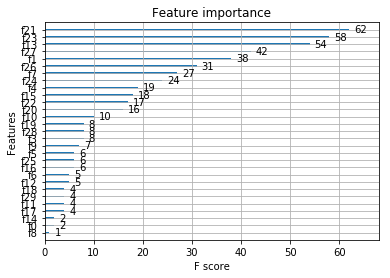

In [53]:
from xgboost import plot_importance
from matplotlib import pyplot

model = XGBClassifier(params=cv.best_params_)

model.fit(X,y)

plot_importance(model)
pyplot.show()